# Machine Translation with Transformers

The dataset used consists of a set of French sentences and their equivalent English translations.

### **Useful links**

* https://pytorch.org/docs/stable/generated/torch.nn.Transformer.html
* https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html


In [8]:
skip_training = False   # You can set it to True if you want to run inference on your trained model. 

Add path to the folder containing csv files.

In [ ]:
path = "dataset_machine_translation" 

Import all necessary libraries.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import os
from collections import Counter

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split
import torch.nn.functional as F
import torch.optim as optim

import warnings
warnings.filterwarnings("ignore")

# Set random seeds for all libraries
import random
random.seed(1)
np.random.seed(1)
torch.manual_seed(1)
torch.cuda.manual_seed(1)
torch.cuda.manual_seed_all(1) 

# Ensure deterministic behavior
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

Select the device

In [13]:
if torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


## Data Preparation


### Tokenizaion

In [ ]:
# Load data
en_df = pd.read_csv(os.path.join(path , 'small_vocab_en.csv'), header=None, usecols=[0])
fr_df = pd.read_csv(os.path.join(path, 'small_vocab_fr.csv'), header=None, usecols=[0])

english_sentences = en_df[0].values
french_sentences = fr_df[0].values

print(f'There are {len(english_sentences)} English sentences in data')
print(f'There are {len(french_sentences)} French sentences in data')
print('Here are some examples:')
e = [ 0, 1000, 3000]
for i in e:
    print(10*"-")
    print(english_sentences[i])
    print(french_sentences[i])
print(100*"_")

There are 137860 English sentences in data
There are 137860 French sentences in data
Here are some examples:
----------
new jersey is sometimes quiet during autumn 
new jersey est parfois calme pendant l' automne 
----------
they like strawberries 
ils aiment les fraises 
----------
she plans to visit the united states next may .
elle envisage de se rendre aux états-unis en mai prochain .
____________________________________________________________________________________________________


In [ ]:
# Tokenize function 
def tokenize(sentences):
    filters = '.?!#$%&()*+,-/:;<=>@«»""[\\]^_`{|}~\t\n'
    
    lowered_sentences=[sentence.lower() for sentence in sentences]
    trans_table=str.maketrans("","",filters)
    cleaned_sentences=[str.translate(lowered_sent,trans_table) for lowered_sent in lowered_sentences]
    tokenized_list=[cleaned_sent.split() for cleaned_sent in cleaned_sentences]
    
 

    
    return tokenized_list
    
# Tokenize English and French sentences
tokenized_en = tokenize(english_sentences)
tokenized_fr = tokenize(french_sentences)
for i in e:
    print(10*"-")
    print(tokenized_en[i])
    print(tokenized_fr[i])

----------
['new', 'jersey', 'is', 'sometimes', 'quiet', 'during', 'autumn']
['new', 'jersey', 'est', 'parfois', 'calme', 'pendant', "l'", 'automne']
----------
['they', 'like', 'strawberries']
['ils', 'aiment', 'les', 'fraises']
----------
['she', 'plans', 'to', 'visit', 'the', 'united', 'states', 'next', 'may']
['elle', 'envisage', 'de', 'se', 'rendre', 'aux', 'étatsunis', 'en', 'mai', 'prochain']


### Building Vocabulary

In [ ]:
# Create vocabulary with special tokens
def build_vocab(tokenized_sentences):
    special_tokens = ["<PAD>", "<SOS>", "<EOS>"]

    counter = Counter()
    for sentence in tokenized_sentences:
        for word in sentence:
            counter[word]=counter[word]+1
    vocab = special_tokens + list(counter.keys())
    word2idx = {word: idx for idx, word in enumerate(vocab)}
    idx2word = {idx: word for word, idx in word2idx.items()}
    
    return word2idx, idx2word

en_word2idx, en_idx2word = build_vocab(tokenized_en)
fr_word2idx, fr_idx2word = build_vocab(tokenized_fr)

print("Here are some examples from our English dictionary: ")
print(100 * "-")

# Display first 10 words and their indices from en_word2idx
for i, (key, value) in enumerate(en_word2idx.items()):
    print(f'word: {key}, index: {value}')
    if i == 9:  # After 10 iterations, break
        break

print(10 * "_")

# Display first 10 indices and their words from en_idx2word
for i, (key, value) in enumerate(en_idx2word.items()):
    print(f'index: {key}, word: {value}')
    if i == 9:  # After 10 iterations, break
        break

Here are some examples from our English dictionary: 
----------------------------------------------------------------------------------------------------
word: <PAD>, index: 0
word: <SOS>, index: 1
word: <EOS>, index: 2
word: new, index: 3
word: jersey, index: 4
word: is, index: 5
word: sometimes, index: 6
word: quiet, index: 7
word: during, index: 8
word: autumn, index: 9
__________
index: 0, word: <PAD>
index: 1, word: <SOS>
index: 2, word: <EOS>
index: 3, word: new
index: 4, word: jersey
index: 5, word: is
index: 6, word: sometimes
index: 7, word: quiet
index: 8, word: during
index: 9, word: autumn


### Dataset Class


In [ ]:
# Dataset class with padding applied in __getitem__
class TranslationDataset(Dataset):
    def __init__(self, src_sentences, tgt_sentences, src_vocab, tgt_vocab, seq_len=30):
        self.src_sentences = src_sentences
        self.tgt_sentences = tgt_sentences
        self.src_vocab = src_vocab
        self.tgt_vocab = tgt_vocab
        self.seq_len = seq_len

    def __len__(self):
        return len(self.src_sentences)

    def pad_sequence(self, tokens, vocab, is_target=False):
    
        tokens = [vocab["<SOS>"]] + [vocab.get(token, vocab["<PAD>"]) for token in tokens]
        tokens.append(vocab["<EOS>"])  
        tokens = tokens[:self.seq_len]  
        tokens += [vocab["<PAD>"]] * (self.seq_len - len(tokens))  
        return tokens

    def __getitem__(self, idx):
        
        src_tokens = self.src_sentences[idx]
        tgt_tokens = self.tgt_sentences[idx]
        
        # Apply padding to both the source and target sentences
        src_padded = self.pad_sequence(src_tokens, self.src_vocab, is_target=False)
        tgt_padded = self.pad_sequence(tgt_tokens, self.tgt_vocab, is_target=True)
        
        # Convert to tensors and move to device (GPU or CPU)
        src_item = torch.tensor(src_padded).to(device)
        tgt_item = torch.tensor(tgt_padded).to(device)
    
        return src_item, tgt_item

# Instantiate and test the dataset, let the French be as source language and English as target language.
dataset = TranslationDataset(tokenized_fr, tokenized_en, fr_word2idx, en_word2idx,  seq_len=10)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

# Test the DataLoader
for src_batch, tgt_batch in dataloader:
    print("Source batch:", src_batch)
    print(src_batch.size())
    print(10*"_")
    print("Target batch:", tgt_batch)
    print(tgt_batch.size())
    print(10*"_")
    break

Source batch: tensor([[  1,   9,  50,   5,  83, 103,  15, 114,   2,   0]])
torch.Size([1, 10])
__________
Target batch: tensor([[ 1, 44,  5, 13, 86,  8, 93,  2,  0,  0]])
torch.Size([1, 10])
__________


### Sentence Embedding

In [ ]:
embedding_size = 128
vsize_src = len(fr_word2idx)
vsize_tgt = len(en_word2idx)

dataset = TranslationDataset(tokenized_fr, tokenized_en, fr_word2idx, en_word2idx,  seq_len=10)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)


src_batch, tgt_batch = next(iter(dataloader))


embedding_fr = nn.Embedding(vsize_src,embedding_size)
embedding_fr.to(device)
output_embedding_fr = embedding_fr(src_batch)

embedding_en = nn.Embedding(vsize_tgt,embedding_size)
embedding_en.to(device)
output_embedding_en = embedding_en(tgt_batch)

print(10*"_")
print(src_batch.size())
print(output_embedding_fr.size())
print(10*"_")
print(tgt_batch.size())
print(output_embedding_en.size())

__________
torch.Size([1, 10])
torch.Size([1, 10, 128])
__________
torch.Size([1, 10])
torch.Size([1, 10, 128])


### Positional encoding
The Positional Encoding layer is used to add this positional information to the word embeddings. It generates a vector for each position in the sequence and combines it with the word embedding to provide both the content and position information.

In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, embed_size, max_len=512):
        super(PositionalEncoding, self).__init__()
        self.embed_size = embed_size
        
        pos_encoding = torch.zeros(max_len, embed_size)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        
    
        div_term = torch.exp(torch.arange(0, self.embed_size, 2)*(-math.log(10000.0)/self.embed_size))
        pos_encoding[:, 0::2] = torch.sin(position * div_term)
        pos_encoding[:, 1::2] = torch.cos(position * div_term)
        
        
        self.register_buffer('pos_encoding', pos_encoding.unsqueeze(0))

    def forward(self, x):
        # Add positional encoding to embeddings
        x = x * math.sqrt(self.embed_size)
        x = x + self.pos_encoding[:, :x.size(1), :].to(x.device)
        return x

In [ ]:
positional_encoding = PositionalEncoding(embedding_size, 512)
output_pe_fr = positional_encoding (output_embedding_fr)
output_pe_en = positional_encoding (output_embedding_en)
print(10*"_")
print(output_pe_fr.size())
print(output_pe_en.size())

__________
torch.Size([1, 10, 128])
torch.Size([1, 10, 128])


## Model Architecture

### Designing a basic transformer block

In [ ]:
class MySimpleTransformer(nn.Module):
    def __init__(self, vocab_size_src, vocab_size_tgt, embed_size, num_heads, hidden_dim, num_encoder_layers, num_decoder_layers, max_len=512):
        super(MySimpleTransformer, self).__init__()
        
        self.embedding_src=nn.Embedding(vocab_size_src,embed_size)
        self.embedding_tgt=nn.Embedding(vocab_size_tgt,embed_size)
        self.positional_encoding=PositionalEncoding(embed_size,max_len)
        self.transformer=nn.Transformer(embed_size,num_heads,num_encoder_layers,num_decoder_layers,hidden_dim)
        self.linear=nn.Linear(embed_size,vocab_size_tgt)
        
        
        
    def forward(self, src, tgt, src_padding_mask=None, tgt_padding_mask=None, tgt_mask=None):
        
        
        
        src = src.transpose(0, 1)
        tgt = tgt.transpose(0, 1)
        if tgt_mask != None:
            tgt_mask = tgt_mask.transpose(0,1)
            
        
        embedded_src = self.embedding_src(src)
        embedded_tgt = self.embedding_tgt(tgt)
        
        embed_pos_src = self.positional_encoding(embedded_src)
        embed_pos_tgt = self.positional_encoding(embedded_tgt)
        transformer_output = self.transformer(
            src=embed_pos_src, 
            tgt=embed_pos_tgt, 
            src_key_padding_mask=src_padding_mask, 
            tgt_key_padding_mask=tgt_padding_mask, 
            tgt_mask=tgt_mask
        )
    
        output = self.linear(transformer_output)
       
        output = output.transpose(0, 1)
        return output
    
    def get_tgt_mask(self, tgt):
        tgt_seq_len = tgt.size(1)
        tgt_mask = self.transformer.generate_square_subsequent_mask(tgt_seq_len).to(tgt.device)
        return tgt_mask
    
    def create_pad_mask(self, matrix):
        
        pad_token = 0
        return (matrix == pad_token)

def get_num_trainable_parameters(model):
    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f'The model has {num_params} trainable parameters.')
    return num_params

In [ ]:

print(src_batch.size())
print(tgt_batch.size())

print(src_padding_mask.size())
print(src_batch.cpu().detach().numpy())
print(src_padding_mask.cpu().detach().numpy())

print(tgt_mask.size())
print(tgt_mask.cpu().detach().numpy())

torch.Size([1, 10])
torch.Size([1, 10])
torch.Size([1, 10])
[[  1  65   5  66   8   9 102   2   0   0]]
[[False False False False False False False False  True  True]]
torch.Size([10, 10])
[[  0. -inf -inf -inf -inf -inf -inf -inf -inf -inf]
 [  0.   0. -inf -inf -inf -inf -inf -inf -inf -inf]
 [  0.   0.   0. -inf -inf -inf -inf -inf -inf -inf]
 [  0.   0.   0.   0. -inf -inf -inf -inf -inf -inf]
 [  0.   0.   0.   0.   0. -inf -inf -inf -inf -inf]
 [  0.   0.   0.   0.   0.   0. -inf -inf -inf -inf]
 [  0.   0.   0.   0.   0.   0.   0. -inf -inf -inf]
 [  0.   0.   0.   0.   0.   0.   0.   0. -inf -inf]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0. -inf]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]]


### Adding Encoder and Decoder blocks

In [ ]:
class MyTransformer(nn.Module):
    def __init__(self, vocab_size_src, vocab_size_tgt, embed_size, num_heads, hidden_dim, num_encoder_layers, num_decoder_layers, max_len=512):
        super(MyTransformer, self).__init__()
        
        self.embedding_src=nn.Embedding(vocab_size_src,embed_size)
        self.embedding_tgt=nn.Embedding(vocab_size_tgt,embed_size)
        self.positional_encoding=PositionalEncoding(embed_size,max_len)
        self.transformer=nn.Transformer(embed_size,num_heads,num_encoder_layers,num_decoder_layers,hidden_dim)
        self.linear=nn.Linear(embed_size,vocab_size_tgt)
        
        
    def encode(self, src, src_padding_mask):
        # Transpose inputs to (seq_len, batch_size, embedding_dim)
        src = src.transpose(0, 1)
        
        src_embedded=self.embedding_src(src)
        src_embedded=self.positional_encoding(src_embedded)
        encoded=self.transformer.encoder(src_embedded, src_key_padding_mask=src_padding_mask)
        
        return encoded

    def decode(self, tgt, memory, tgt_mask, tgt_padding_mask):
        # Transpose inputs to (seq_len, batch_size, embedding_dim)
        tgt = tgt.transpose(0, 1)
        if tgt_mask != None:
            tgt_mask = tgt_mask.transpose(0,1)
       
        tgt_embedded=self.embedding_tgt(tgt)
        tgt_embedded=self.positional_encoding(tgt_embedded)
        decoded=self.transformer.decoder(tgt_embedded, memory, tgt_mask=tgt_mask, tgt_key_padding_mask=tgt_padding_mask)
        
        return decoded

    def forward(self, src, tgt, src_padding_mask=None, tgt_padding_mask=None, tgt_mask=None):
        
        memory=self.encode( src, src_padding_mask)
        output_decoder=self.decode(tgt, memory, tgt_mask, tgt_padding_mask)
        output=self.linear(output_decoder)
        
        output = output.transpose(0, 1)
        return  output_decoder, output 
    
    def get_tgt_mask(self, tgt):
        tgt_seq_len = tgt.size(1)
        tgt_mask = nn.Transformer.generate_square_subsequent_mask(tgt_seq_len).to(tgt.device)
        return tgt_mask
    
    def create_pad_mask(self, matrix):
        
        pad_token = 0
        return (matrix == pad_token)

## Training and Validation

In [ ]:
# Data

bs = 256
dataset = TranslationDataset(tokenized_fr, tokenized_en, fr_word2idx, en_word2idx,  seq_len=7)
number_of_sentences = len(tokenized_fr)
train_size = int((0.8)*number_of_sentences)
test_size = int(number_of_sentences - train_size)
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=bs, shuffle=True, drop_last=True)
val_loader = DataLoader(test_dataset, batch_size=bs, shuffle=False, drop_last=True)

In [ ]:
# Model

embedding_size = 240 
vsize_src = len(fr_word2idx) 
vsize_tgt = len(en_word2idx) 
hdim = 512
model = MyTransformer(vsize_src, vsize_tgt, embedding_size, 6, hdim, 4, 4, max_len=256)
model = model.to(device)

Epoch 1/3, Train Loss: 1.0208
Epoch 1/3, Validation Loss: 0.1396
Epoch 2/3, Train Loss: 0.1306
Epoch 2/3, Validation Loss: 0.0885
Epoch 3/3, Train Loss: 0.0915
Epoch 3/3, Validation Loss: 0.0787
Training completed.


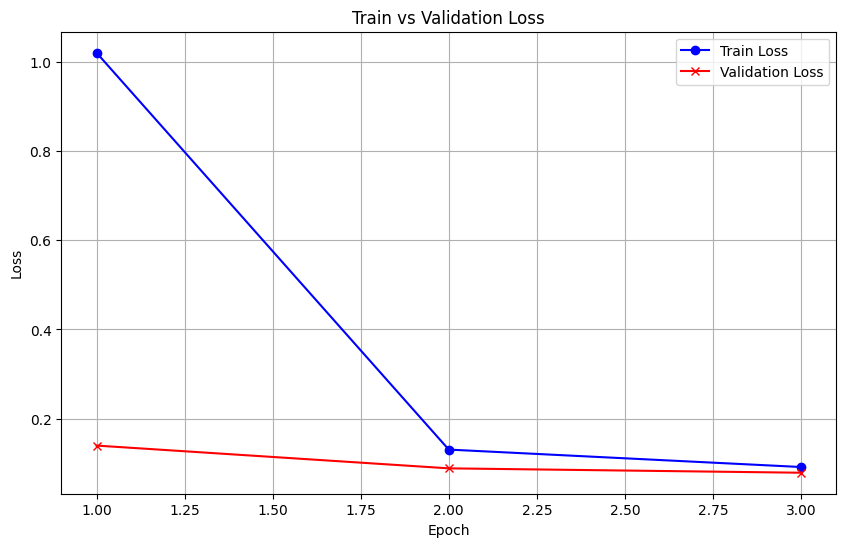

In [ ]:
# Training 
criterion = nn.CrossEntropyLoss()  
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)
num_epochs = 3

if not skip_training:
    epoch_train_losses = []
    epoch_validation_losses = []
    for epoch in range(num_epochs):
        model = model.to(device)
        model.train()  # Set model to training mode
        total_loss = 0
        num_samples = 0
        for src_batch, tgt_batch in train_loader:
            optimizer.zero_grad()
           
            src_input=src_batch
            tgt_input=tgt_batch[:,:-1]
            tgt_expected=tgt_batch[:,1:]
            src_padding_mask = model.create_pad_mask(src_input)
            tgt_padding_mask = model.create_pad_mask(tgt_input).float()
            tgt_mask = model.get_tgt_mask(tgt_input)
            _,output = model(src_input, tgt_input, src_padding_mask, tgt_padding_mask, tgt_mask)
            
            output = output.to(device)
            output = output.contiguous().view(-1, vsize_tgt)
            tgt_expected = tgt_expected.contiguous().view(-1)    
            
            loss = criterion(output, tgt_expected)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            num_samples += src_batch.shape[0]
    
        epoch_train_loss = total_loss / len(train_loader)
        epoch_train_loss = round(epoch_train_loss, 4)
        epoch_train_losses.append(epoch_train_loss)
        print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {epoch_train_loss}")
        
        ################################################################
        
        model.eval()
        validation_loss = 0
        num_samples = 0
        with torch.no_grad():
            for src_batch, tgt_batch in val_loader:
                
                src_input=src_batch
                tgt_input=tgt_batch[:,:-1]
                tgt_expected=tgt_batch[:,1:]
                src_padding_mask = model.create_pad_mask(src_input)
                tgt_padding_mask = model.create_pad_mask(tgt_input).float()
                tgt_mask = model.get_tgt_mask(tgt_input)
                _,output = model(src_input, tgt_input, src_padding_mask, tgt_padding_mask, tgt_mask)
                
                output = output.to(device)
                output = output.contiguous().view(-1, vsize_tgt)
                tgt_expected = tgt_expected.contiguous().view(-1)  
                loss = criterion(output, tgt_expected)
                validation_loss += loss.item()
                num_samples += src_batch.shape[0]
                
            epoch_validation_loss = validation_loss / len(val_loader)
            epoch_validation_loss = round(epoch_validation_loss, 4)
            epoch_validation_losses.append(epoch_validation_loss)
            
        print(f"Epoch {epoch + 1}/{num_epochs}, Validation Loss: {epoch_validation_loss}")
        torch.save(model.state_dict(), 'model.pth')   
            
    print("Training completed.")
    torch.save(model.state_dict(), 'model.pth') 
    
    plt.figure(figsize=(10, 6))
    epochs = range(1, num_epochs + 1)
    plt.plot(epochs, epoch_train_losses, label='Train Loss', color='blue', marker='o')
    plt.plot(epochs, epoch_validation_losses, label='Validation Loss', color='red', marker='x')
    plt.title('Train vs Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

## Autoregressive Translation

In [ ]:
seq_len=10
start_token=1
end_token=2
model.eval()  

# Convert src_sentence to tokenized integers in the vocabulary dictionary 
example_source_sentences = ["new jersey est parfois calme pendant l' automne.", "california est généralement calme en mars."]
example_tokenized = tokenize(example_source_sentences)
src_sentences = []
for ex in example_tokenized:
    ex_inds = []
    for t in ex:
        t_ind = fr_word2idx [t]
        ex_inds.append(t_ind)
    src_sentences.append(ex_inds)    

translated_sequences = []
for counter, src_sentence in enumerate(src_sentences):    
    # Convert source tokens to Tensor 
    src_tensor = torch.tensor(src_sentence, dtype=torch.long).unsqueeze(0).to(device)  # Shape: (1, src_seq_length)
    
    src_padding_mask=model.create_pad_mask(src_tensor)
    memory = model.encode(src_tensor, src_padding_mask)
    
    # initialize the predicted tgt_tokens (translation) with start token
    tgt_tokens = torch.ones(1, 1).fill_(start_token).type(torch.long).to(device) #(1,1)

    for i in range(seq_len-1):
        
        tgt_mask=model.get_tgt_mask(tgt_tokens)
        tgt_padding_mask = model.create_pad_mask(tgt_tokens)
        output = model.decode(tgt_tokens, memory, tgt_mask,tgt_padding_mask)
        output=model.linear(output)
        last_token = output[-1, :, :]
        _,idx=torch.max(last_token,dim=1)
        next_tgt_item = idx.view(1, 1).to(device)
        tgt_tokens = torch.cat((tgt_tokens, next_tgt_item), dim=1)
        if next_tgt_item.item() == end_token:
            break
        
        
    
    translated_tokens = tgt_tokens.squeeze().tolist()
    translated_sentence = ' '.join ([en_idx2word[i] for i in translated_tokens[1:]])
    translated_sequences.append(translated_tokens)
    print("original_sentence:", example_source_sentences[counter])
    print("translated_sentence:", translated_sentence)
    print(10*'-')

np.save('translation.npy', np.array(translated_sequences, dtype=object))

original_sentence: new jersey est parfois calme pendant l' automne.
translated_sentence: automobile during autumn <EOS>
----------
original_sentence: california est généralement calme en mars.
translated_sentence: march <EOS>
----------


We could have added an attention heatmap as well